<a href="https://colab.research.google.com/github/daliaydom/Aprendizaje-Profundo/blob/main/Ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de aprendizaje profundo
## Redes densas
### Dalia Yvette Domínguez Jiménez

#### Ejercicio 4: Red completamente conectada con PyTorch

Se modificó la función que define la arquitectura del modelo (apartado 3), de tal forma que el diseñador pueda definir algunos hiperparámetros como: el número de neuronas, capas, funciones de activación e hiperparámetros.

## 1 Preparación

In [ ]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1 Bibliotecas

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

### 1.2 Auxiliares

In [ ]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

### 2.2 Exploración

PyTorch provee la clase [`MNIST`](https://pytorch.org/vision/0.8/datasets.html#mnist), una implementación de `Dataset` lista para usar del conjunto MNIST.

In [ ]:
# creamos un Dataset
ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # convertir la imagen a ndarray
    transform=np.array,
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


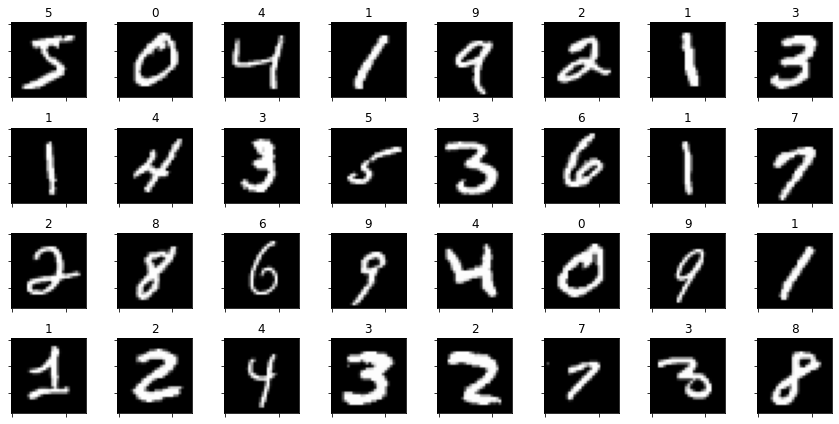

In [ ]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


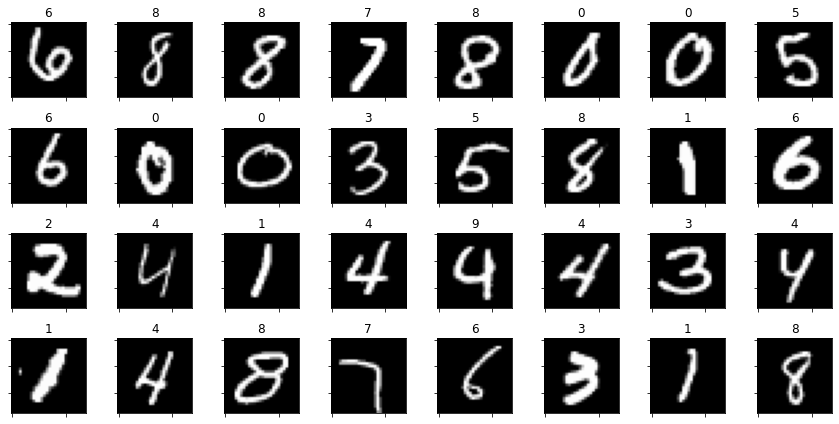

In [ ]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


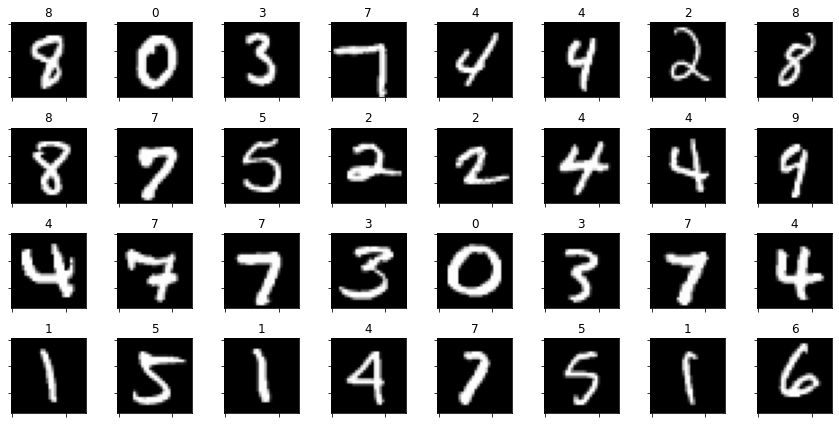

In [ ]:
# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/fc_arch.svg" width="800"/>
&nbsp;
Arquitectura de la red completamente conectada.

### 3.1 Definición de la arquitectura

In [ ]:
# definición del modelo
class FCN(nn.Module):

    # inicializador
    def __init__(self,nfc1=128, nfc2=10, activ_func = nn.Sigmoid()):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = nfc1, nfc2

        # definición de capas (primera parte)
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            activ_func,
            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

## 4 Entrenamiento


### 4.1 Ciclo de entrenamiento

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        # print(f'E{epoch:02} '
        #       f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
        #       f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

## Exploración con diferentes parámetros:

### Con diferente número de neuronas

Arreglo que contiene el número de neuronas que contiene la capa 4 (segunda capa FC)

In [ ]:
list_param = np.linspace(10,128,10,dtype=int)
list_param

array([ 10,  23,  36,  49,  62,  75,  88, 101, 114, 128])

Entrenamos un modelo para cada una de los elementos del arreglo anterior

In [ ]:
loss, acc = [],[]
for param in list_param:
    model = FCN(nfc1=param, nfc2=10, activ_func = nn.Sigmoid())
    loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-3, epochs=10)
    loss.append(loss_hist)
    acc.append(acc_hist)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Graficamos la pérdida y exactitud en el conjunto de entrenamiento y prueba

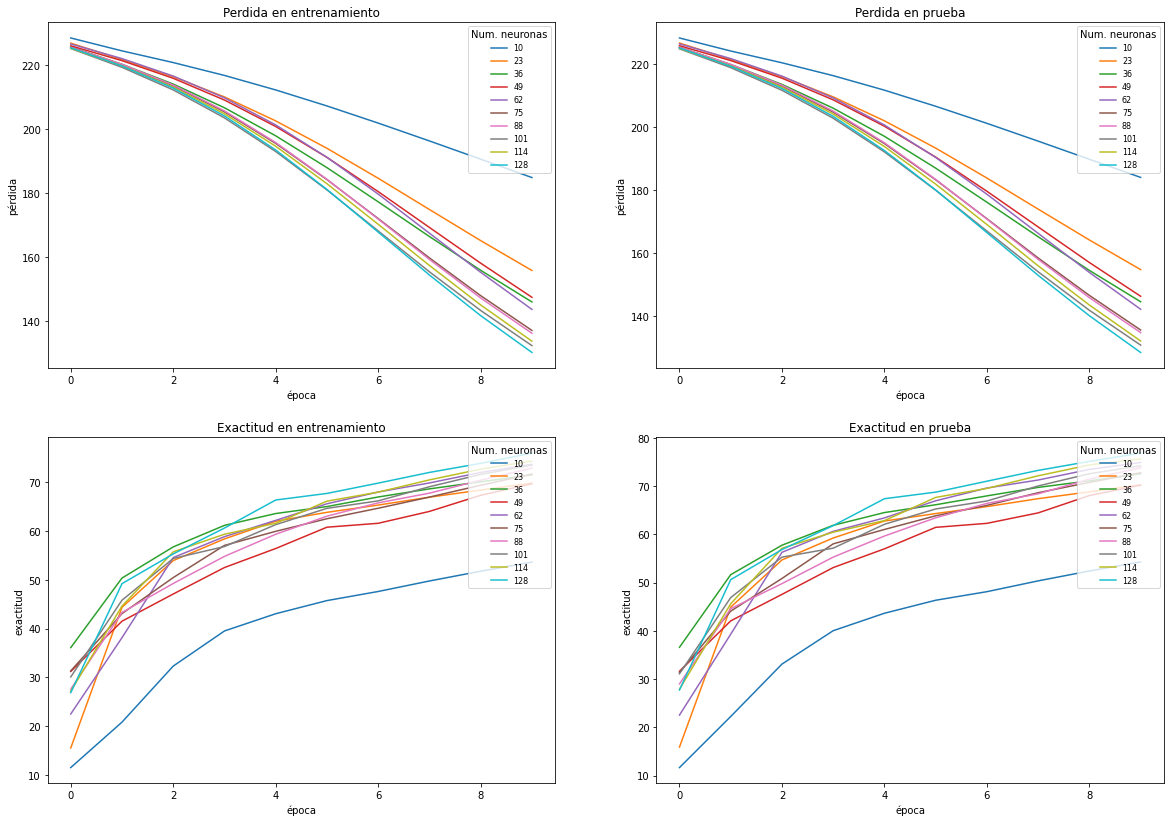

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(20,14))
for loss_hist, acc_hist,param in zip(loss,acc,list_param):
    trn_loss,tst_loss = zip(*loss_hist)
    trn_acc, tst_acc = zip(*acc_hist)
    axs[0,0].plot(trn_loss, label=param)
    axs[0,1].plot(tst_loss, label=param)
    axs[1,0].plot(trn_acc, label=param)
    axs[1,1].plot(tst_acc, label=param)
axs[0,0].set_xlabel('época')
axs[0,0].set_ylabel('pérdida')
axs[0,1].set_xlabel('época')
axs[0,1].set_ylabel('pérdida')
axs[1,0].set_xlabel('época')
axs[1,0].set_ylabel('exactitud')
axs[1,1].set_xlabel('época')
axs[1,1].set_ylabel('exactitud')
axs[0,0].set_title('Perdida en entrenamiento')
axs[0,1].set_title('Perdida en prueba')
axs[1,0].set_title('Exactitud en entrenamiento')
axs[1,1].set_title('Exactitud en prueba')
axs[0,0].legend(title='Num. neuronas',loc='upper right',fontsize=8)
axs[0,1].legend(title='Num. neuronas',loc='upper right',fontsize=8)
axs[1,0].legend(title='Num. neuronas',loc='upper right',fontsize=8)
axs[1,1].legend(title='Num. neuronas',loc='upper right',fontsize=8)
plt.show()

### Con diferente número de capas

Se define las capas que se van a agregar

In [ ]:
b=nn.Sequential(
            nn.Linear(10, 20),
            nn.Sigmoid(),
            nn.Linear(20, 10)
)
b

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=10, bias=True)
)

Se prueba primero el modelo como se diseñó originalmente

In [ ]:
model = FCN()
loss, acc = [],[]
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-3, epochs=10)
loss.append(loss_hist)
acc.append(acc_hist)

  0%|          | 0/10 [00:00<?, ?it/s]

Se 'concatenan' las capas

In [ ]:
model.cls=torch.nn.Sequential(*(list(model.cls)+list(b)))
model

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=128, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=20, out_features=10, bias=True)
  )
)

Y se vuelve a entrenar y evaluar el modelo con la adicción de capas

In [ ]:
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-3, epochs=10)
loss.append(loss_hist)
acc.append(acc_hist)

  0%|          | 0/10 [00:00<?, ?it/s]

Se grafica la pérdida y la exactitud tanto en el conjunto de prueba como en el de entrenamiento.

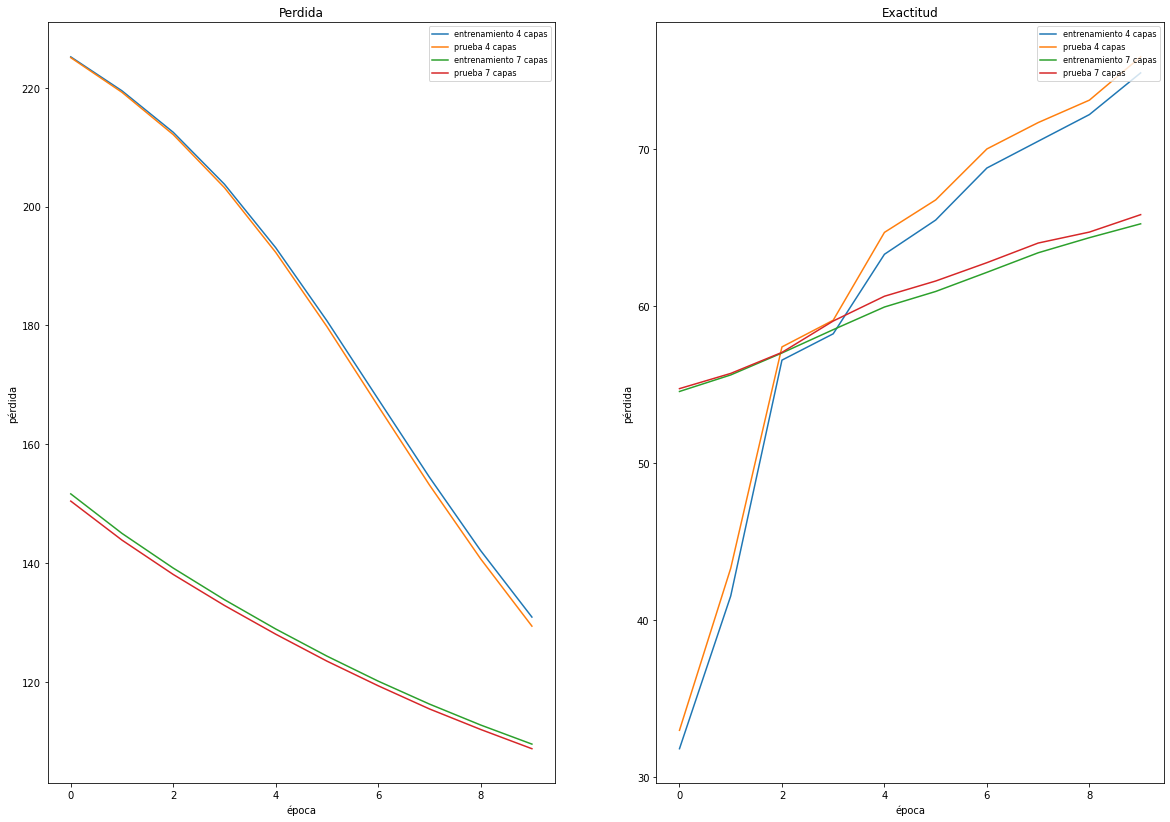

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(20,14))

trn_loss,tst_loss=zip(*loss[0])
axs[0].plot(trn_loss, label='entrenamiento 4 capas')
axs[0].plot(tst_loss, label='prueba 4 capas')
trn_loss,tst_loss=zip(*loss[1])
axs[0].plot(trn_loss, label='entrenamiento 7 capas')
axs[0].plot(tst_loss, label='prueba 7 capas')

trn_acc,tst_acc=zip(*acc[0])
axs[1].plot(trn_acc, label='entrenamiento 4 capas')
axs[1].plot(tst_acc, label='prueba 4 capas')
trn_acc,tst_acc=zip(*acc[1])
axs[1].plot(trn_acc, label='entrenamiento 7 capas')
axs[1].plot(tst_acc, label='prueba 7 capas')

axs[0].set_xlabel('época')
axs[0].set_ylabel('pérdida')
axs[1].set_xlabel('época')
axs[1].set_ylabel('pérdida')
axs[0].legend(loc='upper right',fontsize=8)
axs[1].legend(loc='upper right',fontsize=8)
axs[0].set_title('Perdida')
axs[1].set_title('Exactitud')
plt.show()

### Con diferente tasa de aprendizaje

Tasas de aprendizaje a utilizar (después de probar diferentes rangos):

In [ ]:
list_param = np.linspace(1e-4,1e-3,10)
list_param

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 ])

Entrenamos un modelo para cada tasa de aprendizaje:

In [ ]:
loss, acc = [],[]
for param in list_param:
    model = FCN(nfc1=128, nfc2=10, activ_func = nn.Sigmoid())
    loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=param, epochs=10)
    loss.append(loss_hist)
    acc.append(acc_hist)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Graficamos el desempeño del modelo para cada tasa de aprendizaje

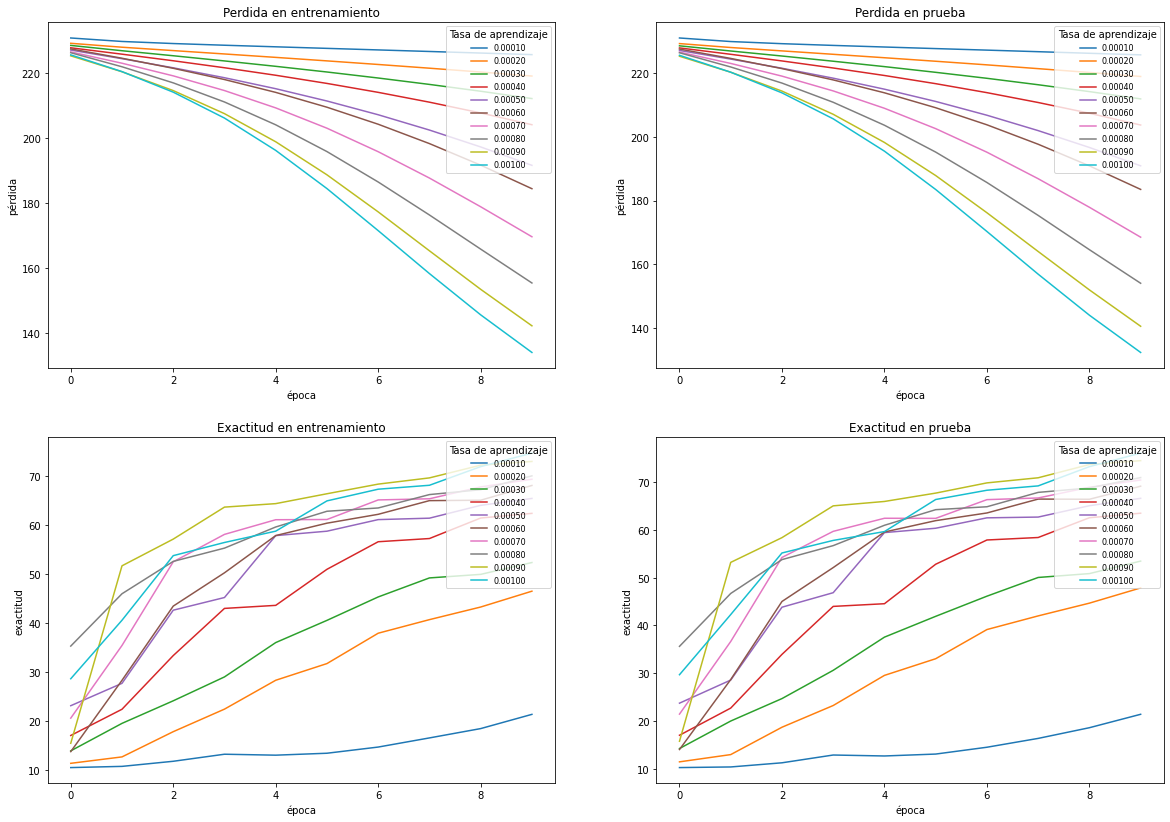

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(20,14))
for loss_hist, acc_hist,param in zip(loss,acc,list_param):
    trn_loss,tst_loss = zip(*loss_hist)
    trn_acc, tst_acc = zip(*acc_hist)
    axs[0,0].plot(trn_loss, label = f'{param:1.5f}')
    axs[0,1].plot(tst_loss, label = f'{param:1.5f}')
    axs[1,0].plot(trn_acc, label = f'{param:1.5f}')
    axs[1,1].plot(tst_acc, label = f'{param:1.5f}')
axs[0,0].set_xlabel('época')
axs[0,0].set_ylabel('pérdida')
axs[0,1].set_xlabel('época')
axs[0,1].set_ylabel('pérdida')
axs[1,0].set_xlabel('época')
axs[1,0].set_ylabel('exactitud')
axs[1,1].set_xlabel('época')
axs[1,1].set_ylabel('exactitud')
axs[0,0].set_title('Perdida en entrenamiento')
axs[0,1].set_title('Perdida en prueba')
axs[1,0].set_title('Exactitud en entrenamiento')
axs[1,1].set_title('Exactitud en prueba')
axs[0,0].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[0,1].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[1,0].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
axs[1,1].legend(title='Tasa de aprendizaje',loc='upper right',fontsize=8)
plt.show()

### Con diferente función de activación

In [ ]:
loss, acc = [],[]
model = FCN(activ_func = nn.Sigmoid())
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-3, epochs=10)
loss.append(loss_hist)
acc.append(acc_hist)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
model = FCN(activ_func = nn.ReLU())
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-3, epochs=10)
loss.append(loss_hist)
acc.append(acc_hist)

  0%|          | 0/10 [00:00<?, ?it/s]

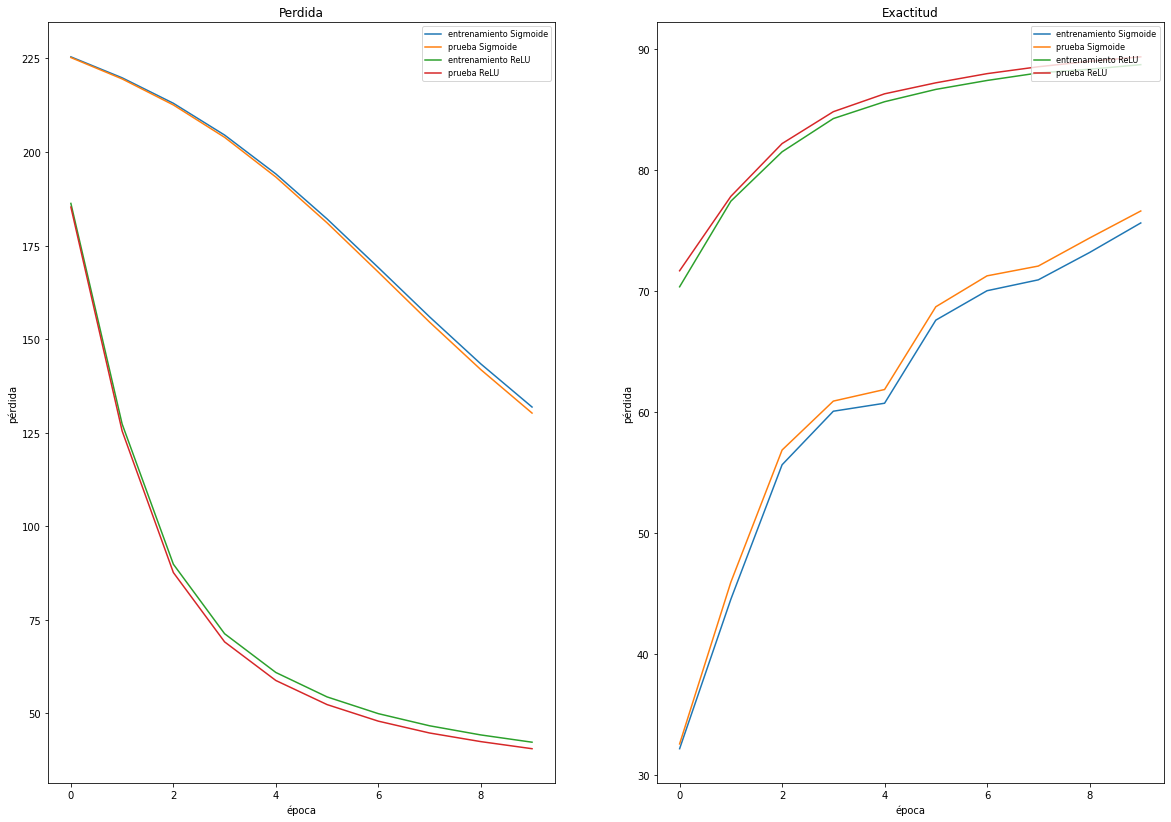

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(20,14))

trn_loss,tst_loss=zip(*loss[0])
axs[0].plot(trn_loss, label='entrenamiento Sigmoide')
axs[0].plot(tst_loss, label='prueba Sigmoide')
trn_loss,tst_loss=zip(*loss[1])
axs[0].plot(trn_loss, label='entrenamiento ReLU')
axs[0].plot(tst_loss, label='prueba ReLU')

trn_acc,tst_acc=zip(*acc[0])
axs[1].plot(trn_acc, label='entrenamiento Sigmoide')
axs[1].plot(tst_acc, label='prueba Sigmoide')
trn_acc,tst_acc=zip(*acc[1])
axs[1].plot(trn_acc, label='entrenamiento ReLU')
axs[1].plot(tst_acc, label='prueba ReLU')

axs[0].set_xlabel('época')
axs[0].set_ylabel('pérdida')
axs[1].set_xlabel('época')
axs[1].set_ylabel('pérdida')
axs[0].legend(loc='upper right',fontsize=8)
axs[1].legend(loc='upper right',fontsize=8)
axs[0].set_title('Perdida')
axs[1].set_title('Exactitud')
plt.show()

## Discusión

La evaluación de los modelos se realizó tanto en el conjunto de entrenamiento como en el de prueba. Tanto la exactitud como la perdida en ambos conjuntos fue muy similar, lo que nos hace pensar ambos conjuntos son muy parecidos, y que el modelo sí está realizadon una generalización. 
Se modificaron 4 hiperparámetros en las arquitecturas:
- El número de neuronas: Entre mayor número de neuronas en la capa segunda capa FC se tiene un caída de la pérdida mayor y el modelo es más exacto, que el caso cuando hay pocas neuronas. Sin embargo, se pudo observar que el costo computacional aumenta considerablemente.
- El número de capas: Al aumentar el número de capas, se incrementa también los parámetros a ajustar y el costo computacional, sin embargo el desempeño no es mejor, pues la exactitud no es mejor (después de 8 épocas) que al tener un modelo con menor número de capas.
- La tasa de aprendizaje: Después de sintonizar en que rango se encontraba una tasa de aprendizaje en donde el modelo convergiera, se observó que al tener una mayor tasa de aprendizaje (1e-3) se tiene una disminución de la pérdida más rápida, sin embargo, con esta tasa no se tiene la mayor exactitud para todas las épocas.
- La función de activación: Al cambiar la función sigmoide por una ReLu, se obtuvo el mejor desempeño en exactitud alcanzando casi el 90%, que al realizar las otras modificaciones, lo que indica que el uso de funciones saturadas no son buena opción al tratarse de redes densas (completamente conectadas).
